In [1]:
import numpy as np
import healpy as hp
from scipy import special
from FreqState import FreqState
from save_galaxy_map import write_map
import h5py
import matplotlib.pyplot as plt

np.random.seed(42)

# Create input map

In [2]:
fmax = 1420
fmin = 1392.0
nfreq = 48

fstate = FreqState()
fstate.freq = (fmax, fmin, nfreq)

ngals = 3

gal_temps = np.random.uniform(size=ngals)
ras = np.random.choice(np.linspace(0,360),size=ngals)
decs = np.random.choice(np.linspace(44.5,45.5),size=ngals)

# to make sure we have consistency
ras_use = np.array([51.42857143, 337.95918367, 249.79591837])
decs_use = np.array([44.76530612, 44.82653061, 45.21428571])

nside = 64
npol = 4

map_ = np.zeros((nfreq, npol, 12* nside**2), dtype=np.float64)
for i in range(nfreq):
    map_[i, 0, hp.ang2pix(nside, ras_use, decs_use, lonlat=True)] += gal_temps

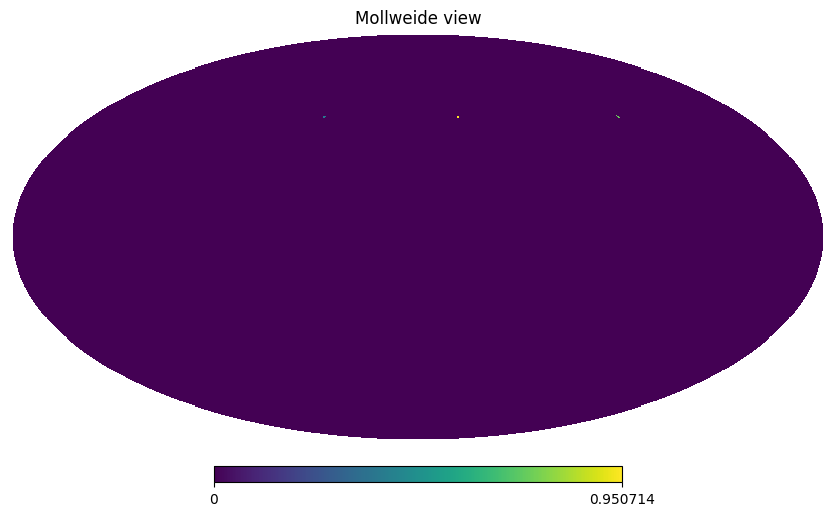

In [3]:
hp.mollview(map_[0,0,:])

In [4]:
write_map('input.h5', map_, fstate.frequencies, fstate.freq_width, include_pol=True)

# Examining the 2D input vs dirty map

In [14]:
f = h5py.File('input.h5')
input_map = np.array(f['map'][:])
f.close()

f = h5py.File('dirty_map.h5')
dirty_map = np.array(f['map'][:])
f.close()

In [15]:
def map_in_ra_dec(Map, nRA=2048, nDec=2048):
    '''converts a healpix map into RA and Dec coordinates (degrees)
        Takes some time to run.
    
    Inputs
    ------
    Map: ndarray
        One-dimensional array containing one slice of healpix map at one polarization
    nRA: int, 2^n
        number of Ra values to sample, dictates map resolution
    nDec: int, 2^n
        number of Dec values to sample, dictates map resolution
    '''
    lat = 49.320751  # CHORD latitude
    ra = np.linspace(0,360,nRA,endpoint=False)
    el = np.linspace(-0.1,-0.04,nDec,endpoint=False)
    za = np.arcsin(el)
    dec = np.degrees(za) + lat

    # This function will convert the healpix map to RA DEC coordinates
    phi = np.radians(ra)
    theta = np.radians(90-dec)
    nside = hp.npix2nside(Map.shape[0])
    map_ra_dec =  np.zeros((dec.shape[0],ra.shape[0]))
    r = hp.rotator.Rotator(coord=['E','E'])

    print('Converting healpix map into RA, Dec coordinates...')
    for ii,tt in enumerate(theta):
        for jj,pp in enumerate(phi):
            theta_g,phi_g = r(tt,pp)
            n = hp.pixelfunc.ang2pix(nside,theta_g,phi_g)
            map_ra_dec[ii,jj] = Map[n]
    return map_ra_dec, ra, dec

In [16]:
input_2d, ra, dec = map_in_ra_dec(input_map[0,0,:],
                                 nRA=256,
                                 nDec=32)
dirty_2d, ra, dec = map_in_ra_dec(dirty_map[0,0,:],
                                 nRA=256,
                                 nDec=32)

Converting healpix map into RA, Dec coordinates...
Converting healpix map into RA, Dec coordinates...


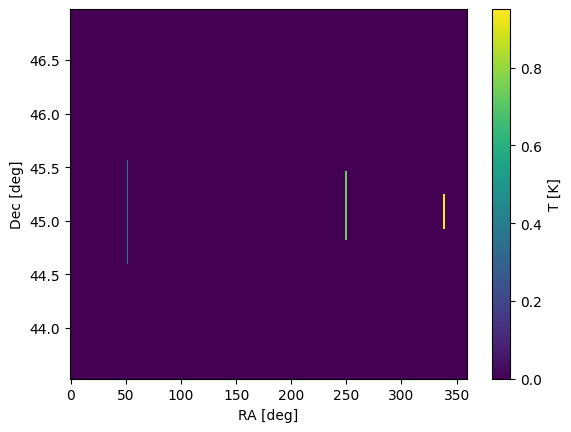

In [9]:
plt.pcolor(ra, dec, input_2d)
plt.ylabel('Dec [deg]')
plt.xlabel('RA [deg]')
plt.colorbar(label='T [K]')
plt.show()

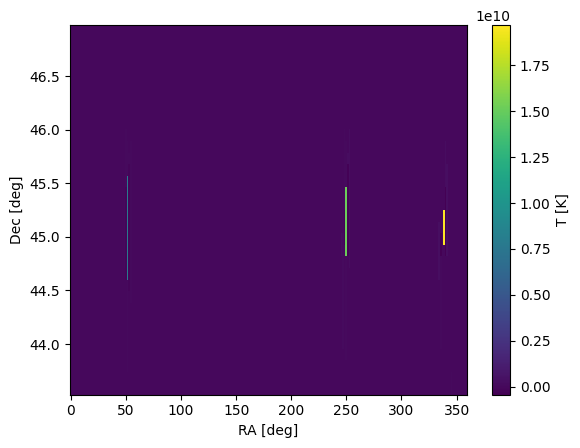

In [17]:
plt.pcolor(ra, dec, dirty_2d)
plt.ylabel('Dec [deg]')
plt.xlabel('RA [deg]')
plt.colorbar(label='T [K]')
plt.show()

# Examining the 1D input vs dirty map

In [23]:
def normalize(array):
    
    return array/np.max(array)

In [10]:
xlims = (6900,7500)

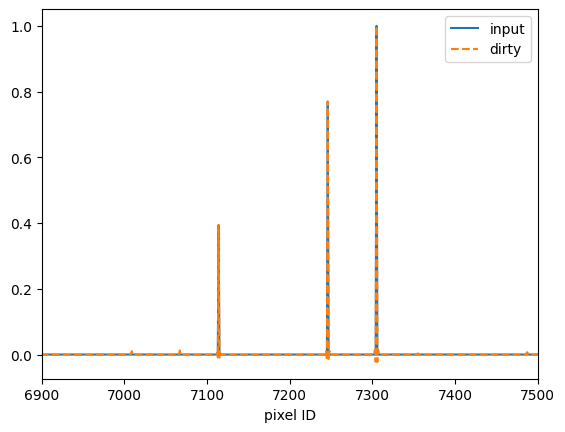

In [27]:
plt.plot(normalize(input_map[0,0,:]), label='input')
plt.plot(normalize(dirty_map[0,0,:]), linestyle='--', label='dirty')
plt.xlim(xlims)
plt.legend()
plt.xlabel('pixel ID')
plt.show()

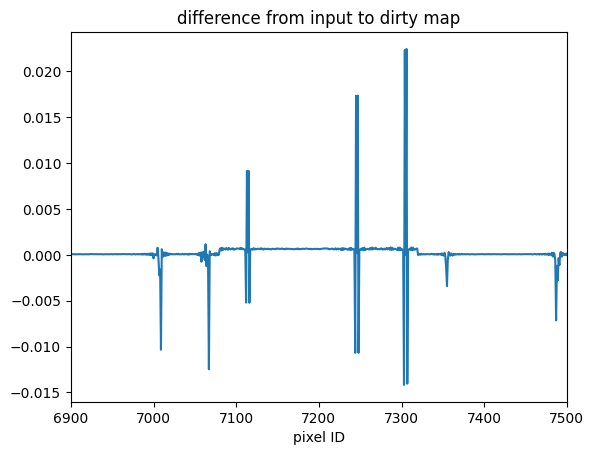

In [29]:
plt.plot(normalize(input_map[0,0,:]) - normalize(dirty_map[0,0,:]))
plt.xlim(xlims)
plt.xlabel('pixel ID')
plt.title('difference from input to dirty map')
plt.show()

# Creating toy model

In [226]:
import mock_map as mm
from astropy import units

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
decs_toy = [43, 45, 44]
ras_toy = [110, 210, 310]

locs_toy = hp.ang2pix(64, ras_toy, decs_toy, lonlat=True)
brights_toy = [1, 1, 1]

In [197]:
npix = hp.nside2npix(64)
toy_1d = mm.create_1d_input_map(npix, 3, locs_toy, brights_toy,seed=100)
toy_obs = mm.perform_observation(toy_1d, None)
toy_noisy = mm.add_noise(toy_obs, 1e-2)

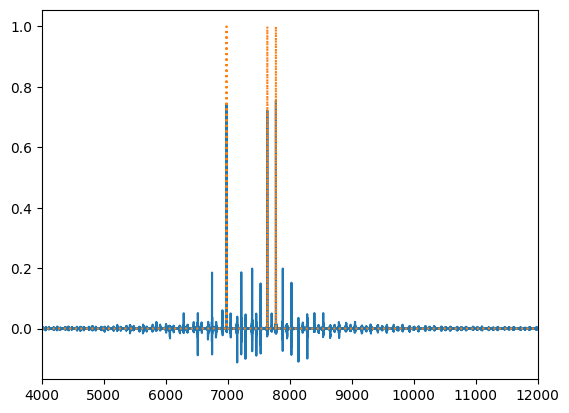

In [201]:
plt.plot(toy_obs)
plt.plot(toy_1d, linestyle=':')
plt.xlim(4000,12000)
plt.show()

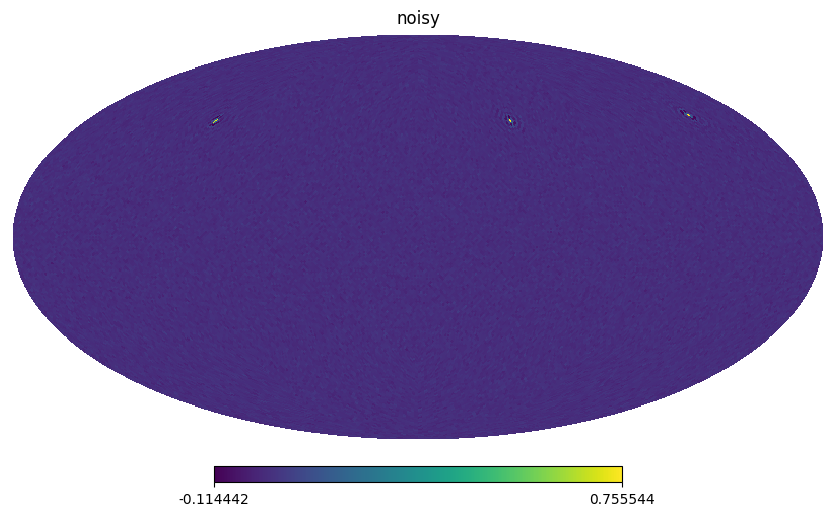

In [202]:
hp.mollview(toy_noisy, title='noisy')

In [219]:
def map_in_ra_dec(Map, nRA=2048, nDec=2048):
    '''converts a healpix map into RA and Dec coordinates (degrees)
        Takes some time to run.
    
    Inputs
    ------
    Map: ndarray
        One-dimensional array containing one slice of healpix map at one polarization
    nRA: int, 2^n
        number of Ra values to sample, dictates map resolution
    nDec: int, 2^n
        number of Dec values to sample, dictates map resolution
    '''
    lat = 49.320751  # CHORD latitude
    ra = np.linspace(50,360,nRA,endpoint=False)
    el = np.linspace(-0.2,-0.0,nDec,endpoint=False)
    za = np.arcsin(el)
    dec = np.degrees(za) + lat

    # This function will convert the healpix map to RA DEC coordinates
    phi = np.radians(ra)
    theta = np.radians(90-dec)
    nside = hp.npix2nside(Map.shape[0])
    map_ra_dec =  np.zeros((dec.shape[0],ra.shape[0]))
    r = hp.rotator.Rotator(coord=['E','E'])

    print('Converting healpix map into RA, Dec coordinates...')
    for ii,tt in enumerate(theta):
        for jj,pp in enumerate(phi):
            theta_g,phi_g = r(tt,pp)
            n = hp.pixelfunc.ang2pix(nside,theta_g,phi_g)
            map_ra_dec[ii,jj] = Map[n]
    return map_ra_dec, ra, dec

In [220]:
toy_2d, ra, dec = map_in_ra_dec(toy_noisy,
                                 nRA=512,
                                 nDec=64)

Converting healpix map into RA, Dec coordinates...


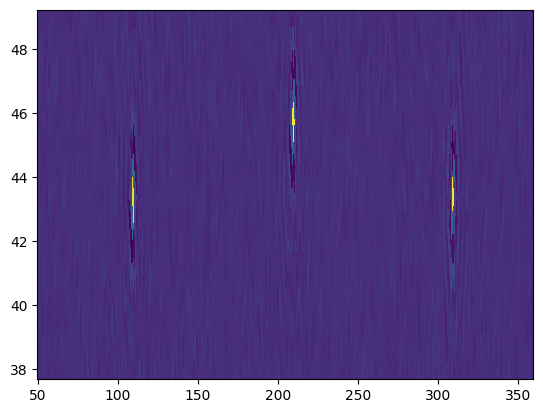

In [221]:
plt.pcolor(ra, dec, toy_2d)
plt.show()

In [335]:
template_1d = np.zeros_like(toy_1d)
template_1d[template_1d.size//2] = 1
template_1d = hp.smoothing(template_1d)

template_2d = np.zeros_like(toy_1d)

mid_pix = hp.ang2pix(64, np.median(ra), np.median(dec), lonlat=True)

template_2d[mid_pix] = 1
template_2d = hp.smoothing(template_2d)

template_2d, ra, dec = map_in_ra_dec(template_2d,
                                 nRA=512,
                                 nDec=64)

Converting healpix map into RA, Dec coordinates...


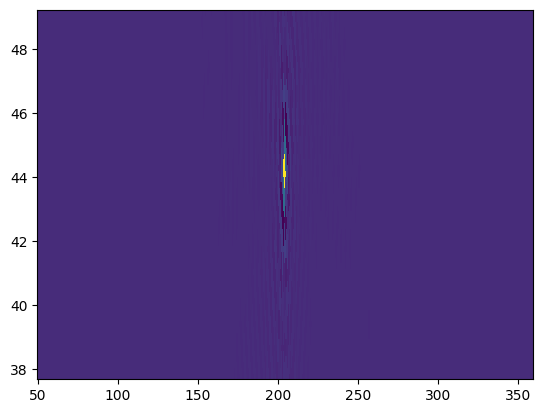

In [336]:
plt.pcolor(ra, dec, template_2d)

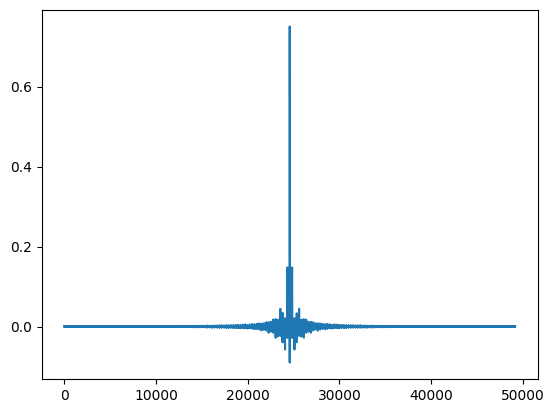

In [337]:
plt.plot(template_1d)

# 2D matched filter

In [338]:
import mf_2d as m2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
pix_size = ((ra.max() - ra.min()) / ra.size)*units.deg.to(units.arcmin) # arcmin

k, Pk = m2.pspec(toy_2d, pix_size)
ps_map = m2.make_map_filter(toy_2d, k, Pk)
mf2d, mf_noise = m2.matched_filter2d(toy_2d, 
                                  template_2d, 
                                  pix_size)

/scratch/rebeccac/spatial_matched_filter/notebooks/mf_2d.py:73: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(np.real(np.sum(mf_ft**2 * pspec_2d)))


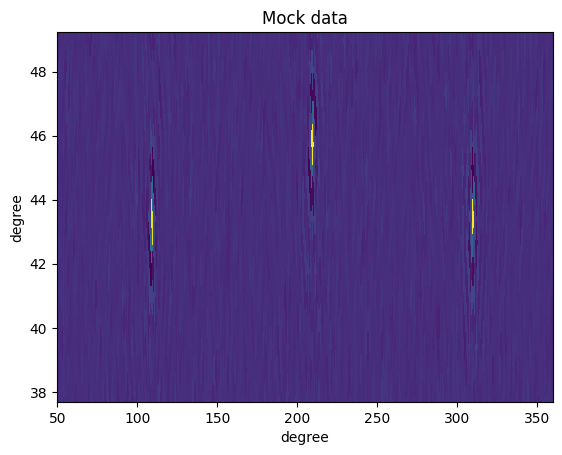

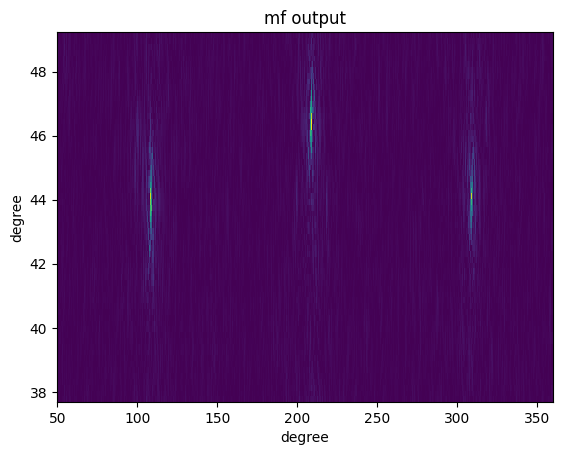

In [340]:
plt.pcolor(ra, dec, toy_2d)
plt.title("Mock data")
plt.xlabel("degree")
plt.ylabel("degree")
plt.show()

plt.pcolor(ra, dec, np.abs(mf2d))
plt.title("mf output")
plt.xlabel("degree")
plt.ylabel("degree")
plt.show()

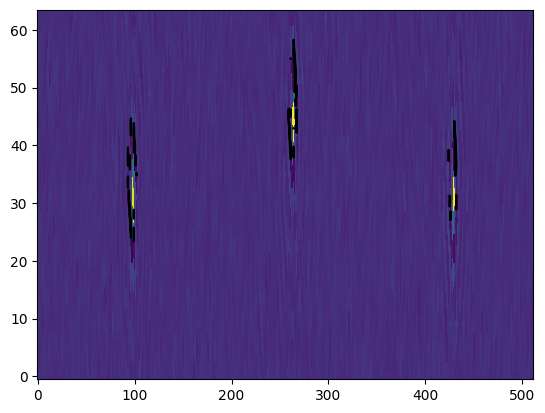

In [364]:
plt.imshow(toy_2d, interpolation='nearest', origin='lower', aspect='auto')
contours = plt.contour(mf2d, 1, levels=[40], colors='black')

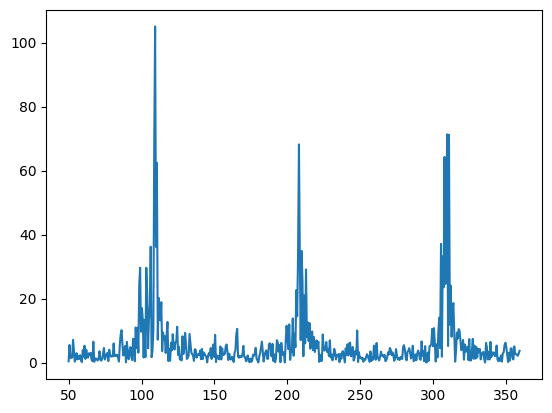

In [361]:
plt.plot(ra, np.abs(mf2d[40,:]))
plt.show()

# 1D matched filter

In [310]:
import mf_1d as m1

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [311]:
mf1d = m1.matched_filter1d(toy_noisy, template_1d, 10)

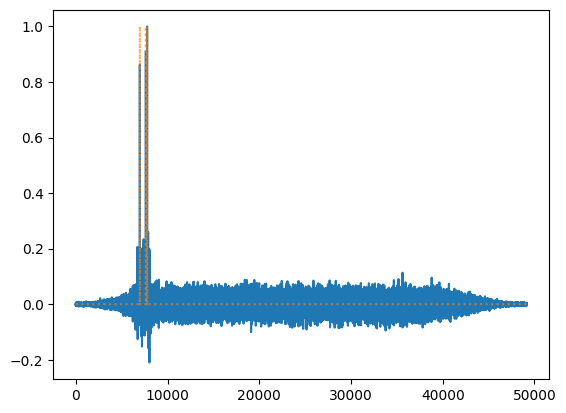

In [320]:
plt.plot(normalize(mf1d))
plt.plot(normalize(toy_1d), ':', alpha=0.7)
plt.show()

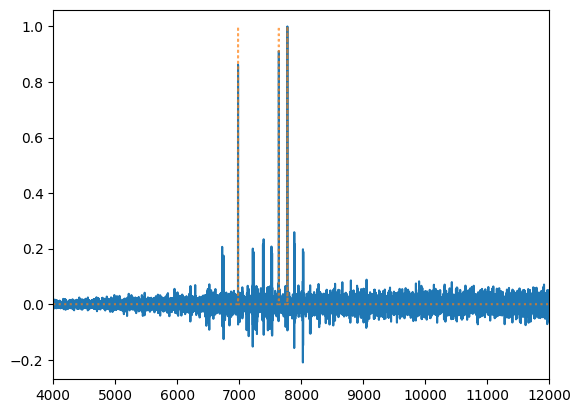

In [324]:
plt.plot(normalize(mf1d))
plt.plot(normalize(toy_1d), ':', alpha=0.7)
plt.xlim(4000,12000)
plt.show()

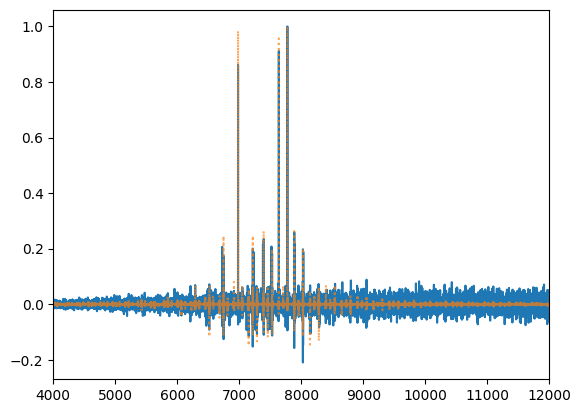

In [325]:
plt.plot(normalize(mf1d))
plt.plot(normalize(toy_obs), ':', alpha=0.7)
plt.xlim(4000,12000)
plt.show()

# next steps: ensuring this is a pro